In [ ]:
 import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
import cv2 as cv
import seaborn as sns
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class skinDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir

    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [ ]:
dataDir="C:/Users/zubeen/Downloads/jubin project/Split_smol/newtrain"

In [ ]:
#dataDir="C:/Users/GPU_CA/Downloads/jubin project/Split_smol/newtrain"

In [ ]:
dataSplit = skinDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

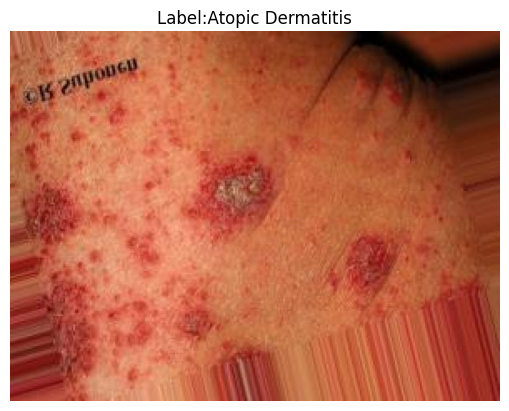

In [ ]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']

    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

In [ ]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'


    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5],
              channel_shift_range=8,
              fill_mode='nearest',
              height_shift_range=0.25,
              zoom_range=0.5,
              )

    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of augmented training images:", train_generator.image_shape)

    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of validation images:", valid_generator.image_shape)

    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )

    print("Shape of test images:", test_generator.image_shape)

    return train_generator, valid_generator, test_generator

In [ ]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 7910 validated image filenames belonging to 9 classes.
Shape of augmented training images: (256, 256, 3)
Found 989 validated image filenames belonging to 9 classes.
Shape of validation images: (256, 256, 3)
Found 989 validated image filenames belonging to 9 classes.
Shape of test images: (256, 256, 3)


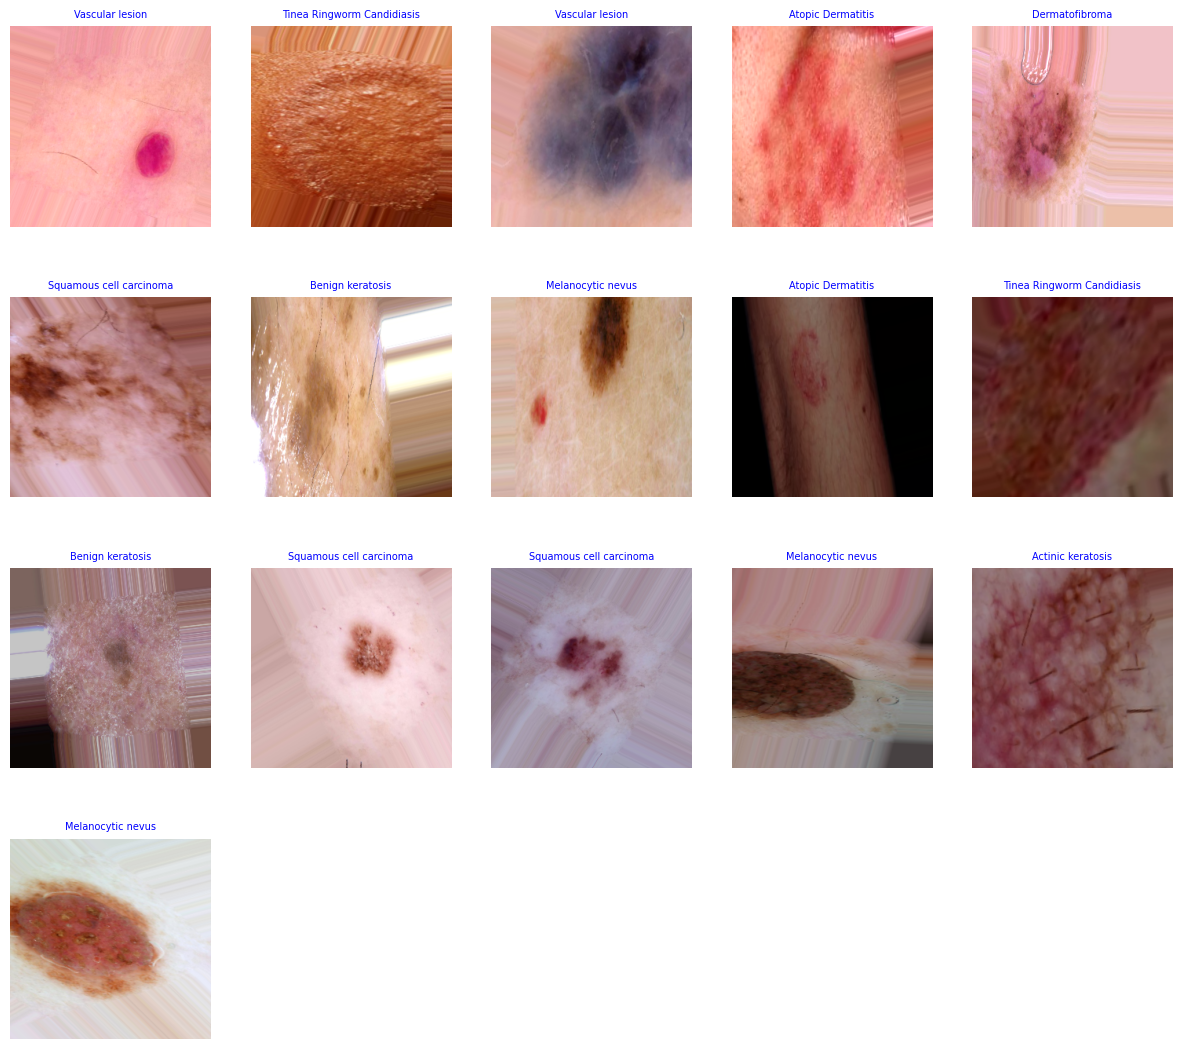

In [ ]:
def show_images(gen):

    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)
    sample = min(length, 20)
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

# ***EfficientNetb6***

In [ ]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 512, 512, 3)  0           ['normalization[0][0]']      

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.498282 to fit



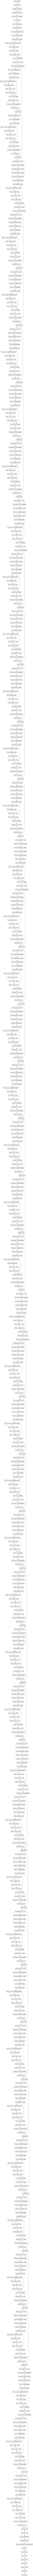

In [ ]:
 from tensorflow.keras.utils import plot_model
import pydot
plot_model(model)

In [ ]:
# Train the model
history = model.fit(
    train_augmented,
    epochs=39,
    batch_size=1,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/39
495/495 [==============================] - 233s 428ms/step - loss: 1.4008 - accuracy: 0.5039 - val_loss: 0.8143 - val_accuracy: 0.6977
Epoch 2/39
495/495 [==============================] - 223s 451ms/step - loss: 0.9135 - accuracy: 0.6710 - val_loss: 0.6903 - val_accuracy: 0.7280
Epoch 3/39
495/495 [==============================] - 244s 492ms/step - loss: 0.7721 - accuracy: 0.7180 - val_loss: 0.6061 - val_accuracy: 0.7644
Epoch 4/39
495/495 [==============================] - 224s 452ms/step - loss: 0.7003 - accuracy: 0.7367 - val_loss: 0.5175 - val_accuracy: 0.8079
Epoch 5/39
495/495 [==============================] - 220s 443ms/step - loss: 0.6344 - accuracy: 0.7668 - val_loss: 0.5051 - val_accuracy: 0.7937
Epoch 6/39
495/495 [==============================] - 214s 431ms/step - loss: 0.5979 - accuracy: 0.7812 - val_loss: 0.3855 - val_accuracy: 0.8483
Epoch 7/39
495/495 [==============================] - 237s 479ms/step - loss: 0.5694 - accuracy: 0.7869 - val_loss: 0.4234 -

In [ ]:
# Save the model
model.save("Effmodel.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_effb6 = load_model("Effmodel.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model_effb6)
tflite_model = converter.convert()
open("Effmodel.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\zubeen\AppData\Local\Temp\tmpefc8t918\assets


INFO:tensorflow:Assets written to: C:\Users\zubeen\AppData\Local\Temp\tmpefc8t918\assets


174796096

Training Accuracy: 0.9216182231903076
Validation Accuracy: 0.9797775745391846


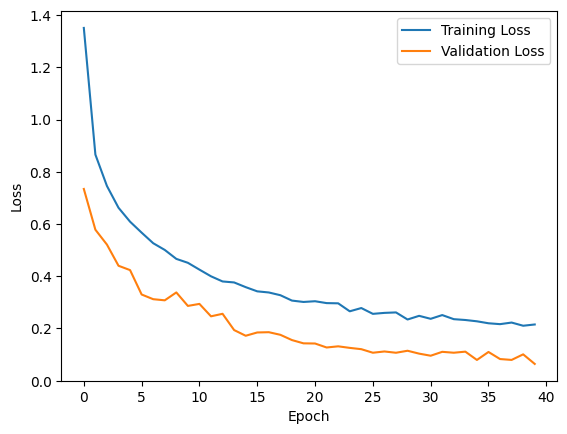

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


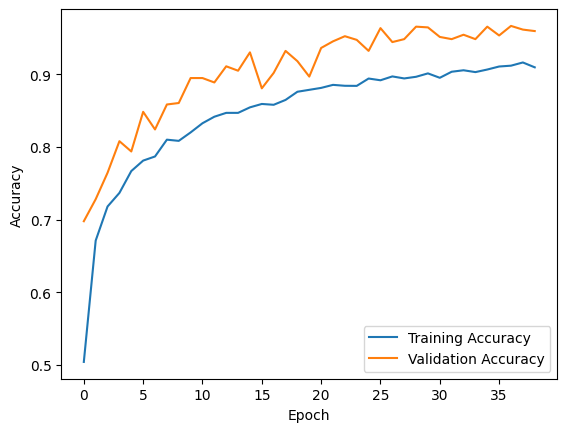

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

62/62 [==============================] - 45s 412ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       113
           1       0.99      1.00      1.00       113
           2       0.95      1.00      0.97       115
           3       0.93      0.98      0.95       115
           4       0.89      0.98      0.93       113
           5       0.94      0.85      0.89       113
           6       0.92      0.88      0.90       113
           7       1.00      1.00      1.00        81
           8       0.98      1.00      0.99       113

    accuracy                           0.95       989
   macro avg       0.95      0.95      0.95       989
weighted avg       0.95      0.95      0.95       989


Confusion Matrix:
[[100   1   1   1   0   1   9   0   0]
 [  0 113   0   0   0   0   0   0   0]
 [  0   0 115   0   0   0   0   0   0]
 [  0   0   0 113   1   1   0   0   0]
 [  0   0   0   0 111   2   0   0   0]
 [

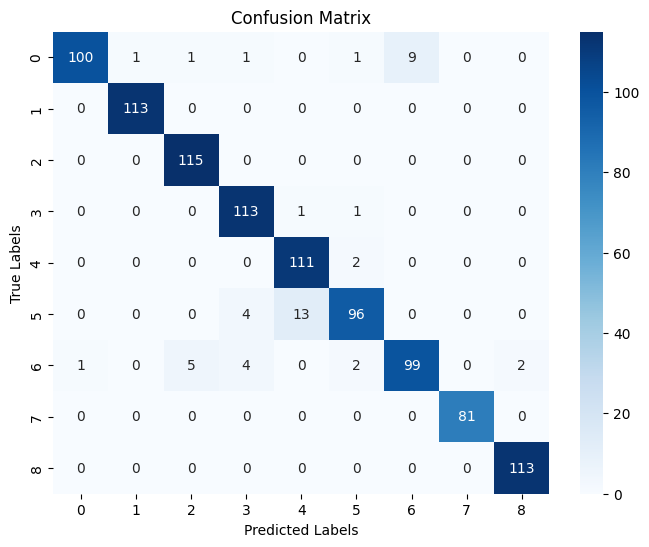

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for the test set
y_pred_prob = loaded_model_effb6.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = loaded_model_effb6.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

# Plotting the standard confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])

Precision: 0.952496391578277
Recall: 0.9514661274014156
F1 score: 0.9508715651247467
Support: 989.0


this has some errors

In [ ]:
from keras.models import load_model
from PIL import Image
import numpy as np

# Load the pre-trained model
model = load_model('Effmodel.h5')

# Load and preprocess the image
img = Image.open("C:/Users/zubeen/Downloads/jubin project/Split_smol/newtrain/Atopic Dermatitis/aug_0_1022.jpg")
img = img.resize((512,512))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Map the predicted class index to a label
class_names = ['Atopic Dermatitis', 'Actinic keratosis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma',
               'Squamous cell carcinoma','Actinic keratosis', 'Vascular lesion']
predicted_label = class_names[predicted_class]
print(f'The predicted label is: {predicted_label}')

1/1 [==============================] - 6s 6s/step
The predicted label is: Actinic keratosis


# ***EfficientNetB7***

In [ ]:
modeleffb7.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 512, 512, 3)  0           ['normalization[0][0]']      

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.40924 to fit



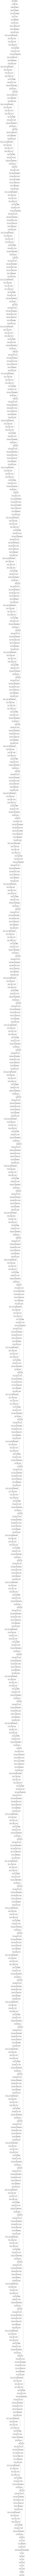

In [ ]:
 from tensorflow.keras.utils import plot_model
import pydot
plot_model(modeleffb7)

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

modeleffb7 = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

modeleffb7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = modeleffb7.fit(
    train_augmented,
    epochs=40,
    batch_size=1,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/40
495/495 [==============================] - 267s 500ms/step - loss: 1.3509 - accuracy: 0.5283 - val_loss: 0.7343 - val_accuracy: 0.7240
Epoch 2/40
495/495 [==============================] - 265s 534ms/step - loss: 0.8659 - accuracy: 0.6834 - val_loss: 0.5782 - val_accuracy: 0.7705
Epoch 3/40
495/495 [==============================] - 264s 534ms/step - loss: 0.7456 - accuracy: 0.7262 - val_loss: 0.5212 - val_accuracy: 0.7867
Epoch 4/40
495/495 [==============================] - 256s 516ms/step - loss: 0.6623 - accuracy: 0.7547 - val_loss: 0.4402 - val_accuracy: 0.8362
Epoch 5/40
495/495 [==============================] - 258s 520ms/step - loss: 0.6089 - accuracy: 0.7775 - val_loss: 0.4235 - val_accuracy: 0.8311
Epoch 6/40
495/495 [==============================] - 252s 508ms/step - loss: 0.5670 - accuracy: 0.7875 - val_loss: 0.3301 - val_accuracy: 0.8726
Epoch 7/40
495/495 [==============================] - 263s 532ms/step - loss: 0.5266 - accuracy: 0.8014 - val_loss: 0.3122 -

In [ ]:
# Save the model
modeleffb7.save("Eff_b7model.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_effb7 = load_model("Eff_b7model.h5")

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("C:/Users/zubeen/EFFicientb6")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

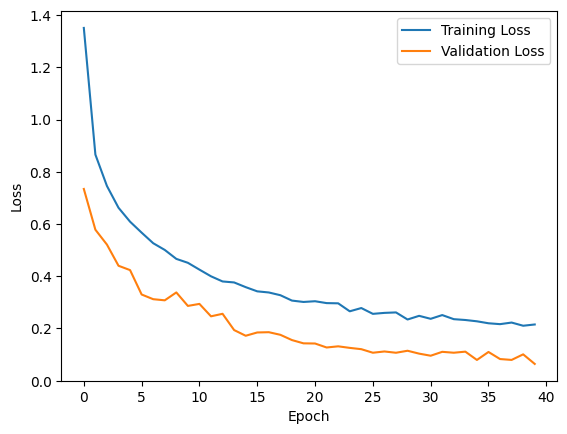

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training Accuracy: 0.9216182231903076
Validation Accuracy: 0.9797775745391846


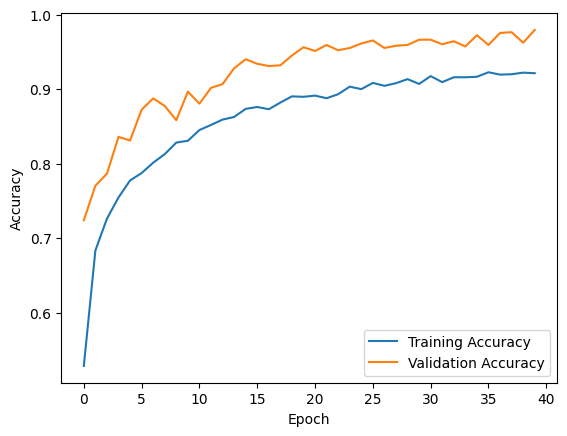

In [ ]:
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

62/62 [==============================] - 37s 484ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       113
           1       1.00      1.00      1.00       113
           2       0.98      1.00      0.99       115
           3       0.99      0.97      0.98       115
           4       1.00      0.97      0.99       113
           5       0.95      0.96      0.95       113
           6       0.85      0.96      0.90       113
           7       1.00      1.00      1.00        81
           8       1.00      1.00      1.00       113

    accuracy                           0.97       989
   macro avg       0.97      0.97      0.97       989
weighted avg       0.97      0.97      0.97       989


Confusion Matrix:
[[101   0   1   0   0   1  10   0   0]
 [  0 113   0   0   0   0   0   0   0]
 [  0   0 115   0   0   0   0   0   0]
 [  0   0   0 111   0   0   4   0   0]
 [  0   0   0   0 110   3   0   0   0]
 [

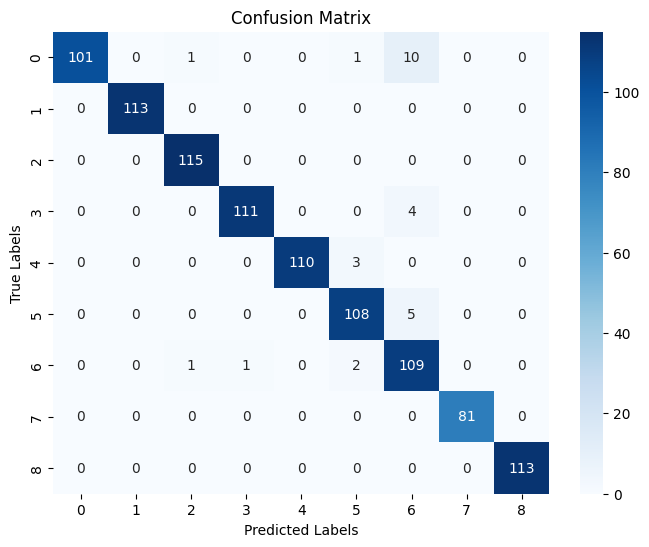

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for the test set
y_pred_prob = loaded_model_effb7.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = loaded_model_effb7.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])

# Plotting the standard confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# ***ResNet50***

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

modelres = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

modelres.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

171446536/171446536 [==============================] - 79s 0us/step


In [ ]:
modelres.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(modelres)

In [ ]:
# Train the model
history_rs = modelres.fit(
    train_augmented,
    epochs=40,
    batch_size=1,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/40
495/495 [==============================] - 160s 313ms/step - loss: 1.4798 - accuracy: 0.4642 - val_loss: 0.7817 - val_accuracy: 0.7149
Epoch 2/40
495/495 [==============================] - 169s 341ms/step - loss: 0.9415 - accuracy: 0.6573 - val_loss: 0.5771 - val_accuracy: 0.7887
Epoch 3/40
495/495 [==============================] - 173s 349ms/step - loss: 0.7844 - accuracy: 0.7145 - val_loss: 0.5729 - val_accuracy: 0.7836
Epoch 4/40
495/495 [==============================] - 155s 312ms/step - loss: 0.6968 - accuracy: 0.7459 - val_loss: 0.4965 - val_accuracy: 0.8210
Epoch 5/40
495/495 [==============================] - 156s 315ms/step - loss: 0.6332 - accuracy: 0.7588 - val_loss: 0.4344 - val_accuracy: 0.8322
Epoch 6/40
495/495 [==============================] - 156s 315ms/step - loss: 0.5714 - accuracy: 0.7833 - val_loss: 0.3510 - val_accuracy: 0.8665
Epoch 7/40
495/495 [==============================] - 157s 318ms/step - loss: 0.5388 - accuracy: 0.8011 - val_loss: 0.4046 -

In [ ]:
# Save the model
modelres.save("Resnet_model.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_res50 = load_model("Resnet_model.h5")

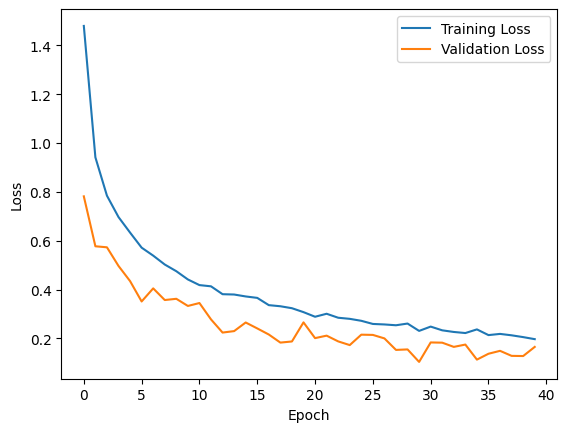

In [ ]:
train_accuracy = history_rs.history['accuracy']
val_accuracy = history_rs.history['val_accuracy']
plt.plot(history_rs.history['loss'], label='Training Loss')
plt.plot(history_rs.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training Accuracy: 0.9270543456077576
Validation Accuracy: 0.9453994035720825


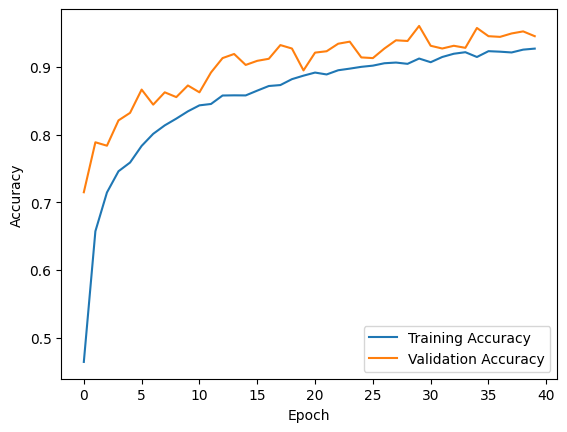

In [ ]:
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history_rs.history['accuracy'], label='Training Accuracy')
plt.plot(history_rs.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

62/62 [==============================] - 21s 265ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       113
           1       1.00      1.00      1.00       113
           2       0.93      1.00      0.97       115
           3       0.85      0.97      0.91       115
           4       0.94      1.00      0.97       113
           5       0.93      0.96      0.95       113
           6       0.96      0.73      0.83       113
           7       1.00      1.00      1.00        81
           8       0.99      0.97      0.98       113

    accuracy                           0.95       989
   macro avg       0.95      0.95      0.95       989
weighted avg       0.95      0.95      0.95       989


Confusion Matrix:
[[104   0   3   3   0   2   1   0   0]
 [  0 113   0   0   0   0   0   0   0]
 [  0   0 115   0   0   0   0   0   0]
 [  0   0   0 112   0   0   2   0   1]
 [  0   0   0   0 113   0   0   0   0]
 [

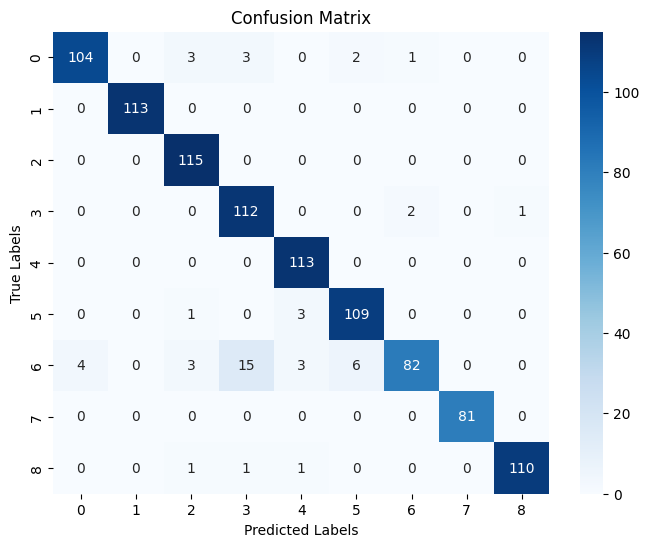

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for the test set
y_pred_prob = loaded_model_res50.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = loaded_model_res50.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])

# Plotting the standard confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ***VGG19***

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

modelvgg = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

modelvgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelvgg.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(modelvgg)

In [ ]:
# Train the model
history_vgg = modelvgg.fit(
    train_augmented,
    epochs=40,
    batch_size=1,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/40
495/495 [==============================] - 166s 328ms/step - loss: 1.9538 - accuracy: 0.3374 - val_loss: 1.1946 - val_accuracy: 0.5541
Epoch 2/40
495/495 [==============================] - 165s 334ms/step - loss: 1.3610 - accuracy: 0.5177 - val_loss: 0.9137 - val_accuracy: 0.6532
Epoch 3/40
495/495 [==============================] - 168s 339ms/step - loss: 1.1522 - accuracy: 0.5898 - val_loss: 0.8306 - val_accuracy: 0.6815
Epoch 4/40
495/495 [==============================] - 167s 337ms/step - loss: 1.0243 - accuracy: 0.6268 - val_loss: 0.7901 - val_accuracy: 0.6866
Epoch 5/40
495/495 [==============================] - 168s 338ms/step - loss: 0.9331 - accuracy: 0.6674 - val_loss: 0.6445 - val_accuracy: 0.7432
Epoch 6/40
495/495 [==============================] - 164s 332ms/step - loss: 0.8910 - accuracy: 0.6776 - val_loss: 0.6153 - val_accuracy: 0.7634
Epoch 7/40
495/495 [==============================] - 166s 336ms/step - loss: 0.8199 - accuracy: 0.7024 - val_loss: 0.6295 -

In [ ]:
# Save the model
modelvgg.save("vgg19_model.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_vgg19 = load_model("vgg19_model.h5")

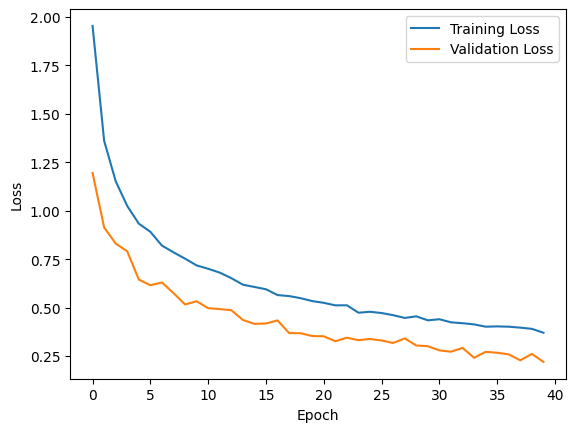

In [ ]:
train_accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training Accuracy: 0.8680151700973511
Validation Accuracy: 0.9221435785293579


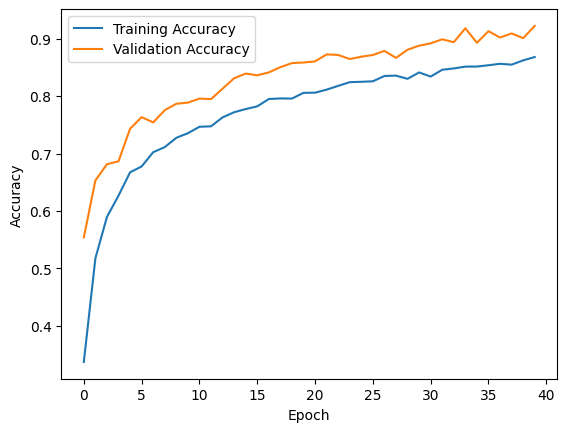

In [ ]:
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

62/62 [==============================] - 25s 336ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       113
           1       0.98      1.00      0.99       113
           2       0.91      0.97      0.94       115
           3       0.86      0.93      0.89       115
           4       0.89      0.89      0.89       113
           5       0.85      0.93      0.89       113
           6       0.84      0.70      0.76       113
           7       1.00      0.99      0.99        81
           8       0.97      0.98      0.98       113

    accuracy                           0.91       989
   macro avg       0.91      0.91      0.91       989
weighted avg       0.91      0.91      0.91       989


Confusion Matrix:
[[ 91   1   3   6   0   3   8   0   1]
 [  0 113   0   0   0   0   0   0   0]
 [  0   0 112   1   1   1   0   0   0]
 [  0   0   0 107   1   1   6   0   0]
 [  0   0   0   0 101  12   0   0   0]
 [

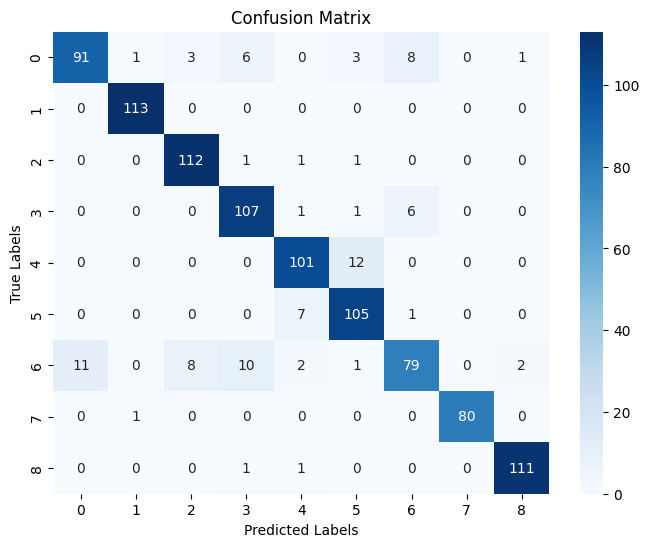

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict probabilities for the test set
y_pred_prob = loaded_model_vgg19.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = loaded_model_vgg19.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])

# Plotting the standard confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ***ResNet101***

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

modelres101 = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

modelres101.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
historyres101 = modelres101.fit(
    train_augmented,
    epochs=40,
    batch_size=8,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/40
495/495 [==============================] - 193s 362ms/step - loss: 1.5147 - accuracy: 0.4609 - val_loss: 0.8379 - val_accuracy: 0.7159
Epoch 2/40
495/495 [==============================] - 182s 368ms/step - loss: 1.0049 - accuracy: 0.6306 - val_loss: 0.6581 - val_accuracy: 0.7523
Epoch 3/40
495/495 [==============================] - 181s 365ms/step - loss: 0.8331 - accuracy: 0.6962 - val_loss: 0.5364 - val_accuracy: 0.8049
Epoch 4/40
495/495 [==============================] - 181s 365ms/step - loss: 0.7389 - accuracy: 0.7281 - val_loss: 0.5164 - val_accuracy: 0.8129
Epoch 5/40
495/495 [==============================] - 181s 365ms/step - loss: 0.6814 - accuracy: 0.7466 - val_loss: 0.4678 - val_accuracy: 0.8291
Epoch 6/40
495/495 [==============================] - 156s 315ms/step - loss: 0.6136 - accuracy: 0.7718 - val_loss: 0.4267 - val_accuracy: 0.8372
Epoch 7/40
495/495 [==============================] - 148s 300ms/step - loss: 0.5804 - accuracy: 0.7823 - val_loss: 0.4240 -

In [ ]:
# Save the model
modelres101.save("MblV2model.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_mblv2 = load_model("MblV2model.h5")

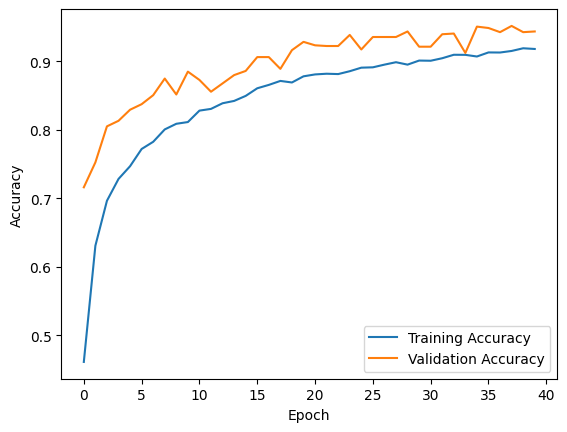

In [ ]:
plt.plot(historyres101.history['accuracy'], label='Training Accuracy')
plt.plot(historyres101.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Training Accuracy: 0.9178255200386047
Validation Accuracy: 0.9433771371841431


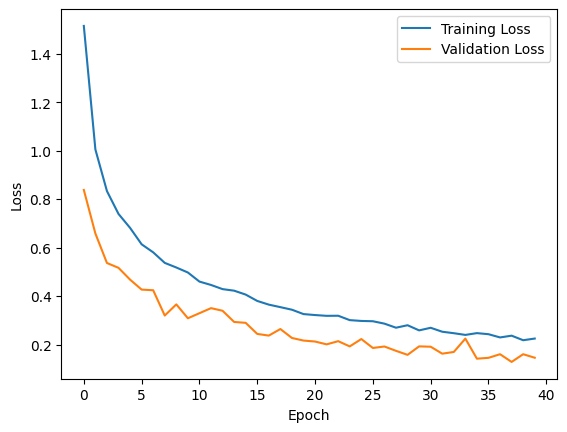

In [ ]:
train_accuracy = historyres101.history['accuracy']
val_accuracy = historyres101.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(historyres101.history['loss'], label='Training Loss')
plt.plot(historyres101.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import seaborn as sns

62/62 [==============================] - 12s 187ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       113
           1       1.00      1.00      1.00       113
           2       0.99      1.00      1.00       115
           3       0.97      0.94      0.96       115
           4       0.86      1.00      0.93       113
           5       0.96      0.86      0.91       113
           6       0.94      0.90      0.92       113
           7       1.00      0.99      0.99        81
           8       0.97      1.00      0.99       113

    accuracy                           0.96       989
   macro avg       0.96      0.96      0.96       989
weighted avg       0.96      0.96      0.96       989


Confusion Matrix:
[[106   0   1   1   1   1   3   0   0]
 [  0 113   0   0   0   0   0   0   0]
 [  0   0 115   0   0   0   0   0   0]
 [  0   0   0 108   0   1   4   0   2]
 [  0   0   0   0 113   0   0   0   0]
 [

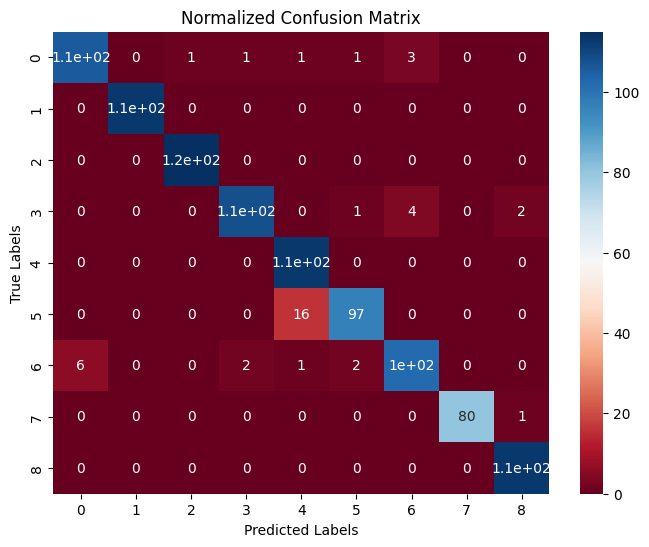

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for the test set
y_pred_prob = modelres101.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = modelres101.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='RdBu')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# ***MobilenetV2***

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

modelmbl = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

modelmbl.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelmbl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                             

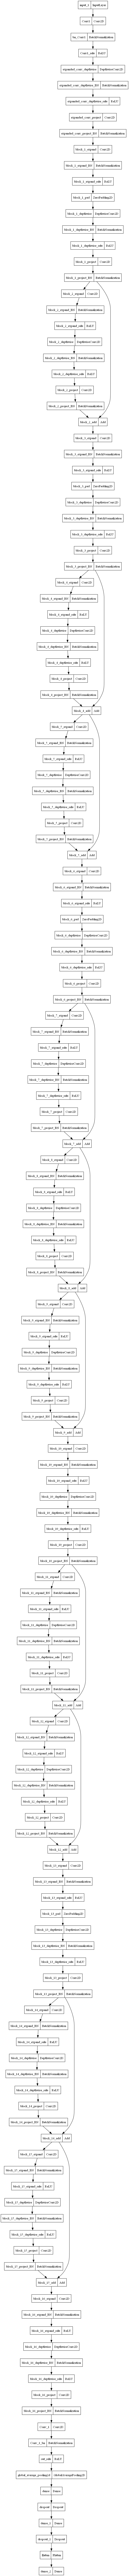

In [ ]:
 from tensorflow.keras.utils import plot_model
import pydot
plot_model(modelmbl)

In [ ]:
# Train the model
historymbl = modelmbl.fit(
    train_augmented,
    epochs=40,
    batch_size=8,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/40
495/495 [==============================] - 142s 286ms/step - loss: 1.8210 - accuracy: 0.3234 - val_loss: 1.5800 - val_accuracy: 0.3893
Epoch 2/40
495/495 [==============================] - 135s 272ms/step - loss: 1.6360 - accuracy: 0.3928 - val_loss: 1.5320 - val_accuracy: 0.4034
Epoch 3/40
495/495 [==============================] - 135s 273ms/step - loss: 1.5202 - accuracy: 0.4466 - val_loss: 1.5046 - val_accuracy: 0.4348
Epoch 4/40
495/495 [==============================] - 136s 275ms/step - loss: 1.4604 - accuracy: 0.4584 - val_loss: 1.5183 - val_accuracy: 0.4287
Epoch 5/40
495/495 [==============================] - 135s 272ms/step - loss: 1.4143 - accuracy: 0.4807 - val_loss: 1.4263 - val_accuracy: 0.4692
Epoch 6/40
495/495 [==============================] - 133s 268ms/step - loss: 1.3687 - accuracy: 0.4884 - val_loss: 1.3766 - val_accuracy: 0.4742
Epoch 7/40
495/495 [==============================] - 131s 265ms/step - loss: 1.3451 - accuracy: 0.5049 - val_loss: 1.3748 -

In [ ]:
# Save the model
modelmbl.save("MblV2model.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_mblv2 = load_model("MblV2model.h5")

Training Accuracy: 0.6281921863555908
Validation Accuracy: 0.5146612524986267


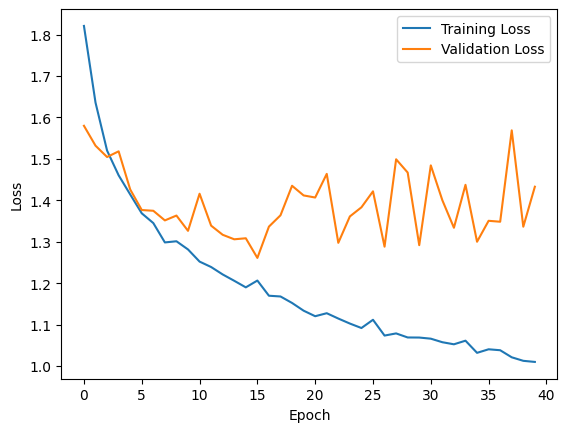

In [ ]:
train_accuracy = historymbl.history['accuracy']
val_accuracy = historymbl.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(historymbl.history['loss'], label='Training Loss')
plt.plot(historymbl.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


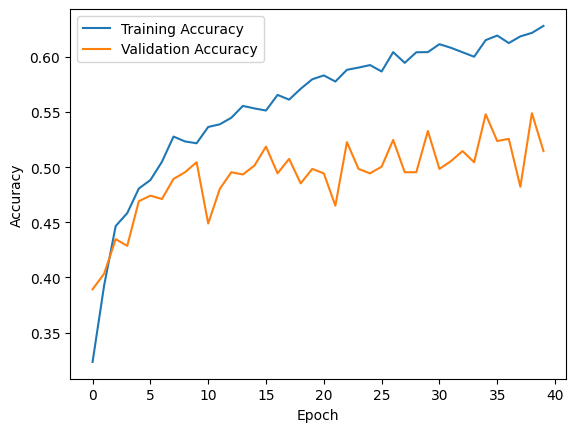

In [ ]:
plt.plot(historymbl.history['accuracy'], label='Training Accuracy')
plt.plot(historymbl.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

62/62 [==============================] - 12s 66ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.19      0.28       113
           1       0.80      0.78      0.79       113
           2       0.57      0.81      0.67       115
           3       0.27      0.61      0.38       115
           4       0.64      0.77      0.70       113
           5       0.46      0.54      0.50       113
           6       0.37      0.09      0.14       113
           7       0.64      0.56      0.60        81
           8       0.81      0.41      0.54       113

    accuracy                           0.53       989
   macro avg       0.57      0.53      0.51       989
weighted avg       0.57      0.53      0.51       989


Confusion Matrix:
[[21  0 12 68  0  1  7  4  0]
 [ 0 88  7  5  0  5  4  2  2]
 [ 0  0 93  1  0 19  0  2  0]
 [ 2  2 10 70  4  8  1 16  2]
 [ 0  0  1  4 87 21  0  0  0]
 [ 0  0 14  6 31 61  0  1  0]
 [ 9  1 18 49  3 1

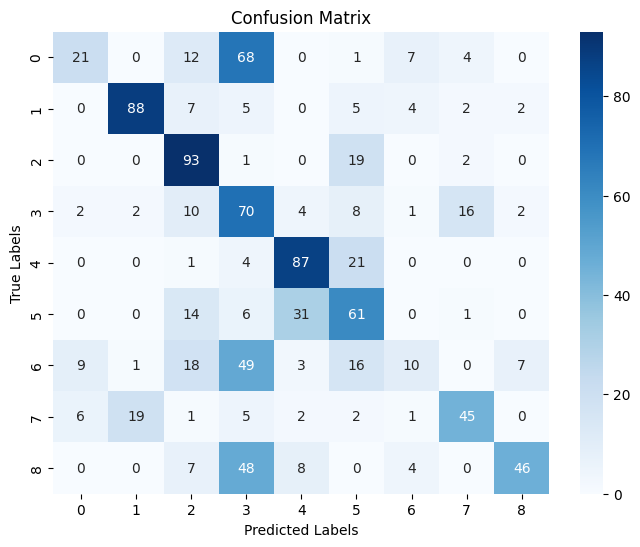

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for the test set
y_pred_prob = loaded_model_mblv2.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = loaded_model_mblv2.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])

# Plotting the standard confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# ***DenseNet169***

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

modeldns = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

modeldns.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modeldns.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
 from tensorflow.keras.utils import plot_model
import pydot
plot_model(modeldns)

In [ ]:
# Train the model
historydns = modeldns.fit(
    train_augmented,
    epochs=40,
    batch_size=1,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/40
495/495 [==============================] - 158s 283ms/step - loss: 2.9065 - accuracy: 0.2876 - val_loss: 1.3819 - val_accuracy: 0.4995
Epoch 2/40
495/495 [==============================] - 137s 276ms/step - loss: 1.6556 - accuracy: 0.4070 - val_loss: 1.2211 - val_accuracy: 0.5824
Epoch 3/40
495/495 [==============================] - 140s 283ms/step - loss: 1.5019 - accuracy: 0.4525 - val_loss: 1.1423 - val_accuracy: 0.5814
Epoch 4/40
495/495 [==============================] - 139s 281ms/step - loss: 1.3707 - accuracy: 0.4975 - val_loss: 1.0531 - val_accuracy: 0.5996
Epoch 5/40
495/495 [==============================] - 140s 282ms/step - loss: 1.2779 - accuracy: 0.5327 - val_loss: 0.9586 - val_accuracy: 0.6380
Epoch 6/40
495/495 [==============================] - 141s 286ms/step - loss: 1.2068 - accuracy: 0.5541 - val_loss: 0.9623 - val_accuracy: 0.6249
Epoch 7/40
495/495 [==============================] - 141s 285ms/step - loss: 1.1423 - accuracy: 0.5770 - val_loss: 0.9357 -

In [ ]:
# Save the model
modeldns.save("dns169model.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_dns169 = load_model("dns169model.h5")

Training Accuracy: 0.7663716673851013
Validation Accuracy: 0.791708767414093


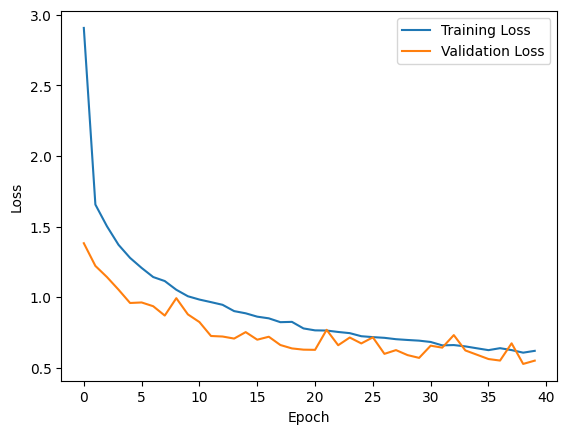

In [ ]:
train_accuracy = historydns.history['accuracy']
val_accuracy = historydns.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(historydns.history['loss'], label='Training Loss')
plt.plot(historydns.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


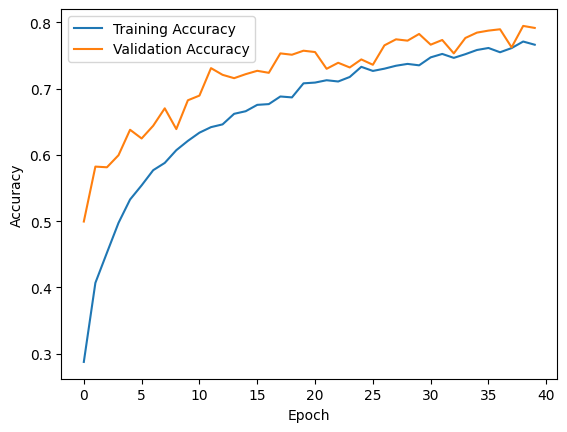

In [ ]:
plt.plot(historydns.history['accuracy'], label='Training Accuracy')
plt.plot(historydns.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

62/62 [==============================] - 12s 135ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       113
           1       0.96      0.97      0.97       113
           2       0.78      0.95      0.85       115
           3       0.61      0.84      0.71       115
           4       0.76      0.93      0.84       113
           5       0.91      0.61      0.73       113
           6       0.83      0.52      0.64       113
           7       0.89      0.91      0.90        81
           8       0.98      0.81      0.88       113

    accuracy                           0.81       989
   macro avg       0.83      0.82      0.81       989
weighted avg       0.83      0.81      0.81       989


Confusion Matrix:
[[ 90   1   2  16   0   0   4   0   0]
 [  0 110   0   0   0   0   1   2   0]
 [  0   0 109   1   0   0   0   5   0]
 [  1   0   9  97   2   0   5   0   1]
 [  0   0   0   2 105   4   0   1   1]
 [

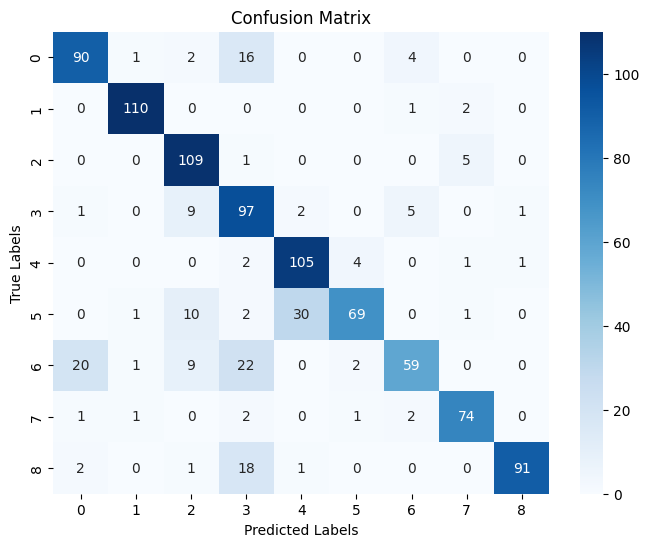

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for the test set
y_pred_prob = loaded_model_dns169.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = loaded_model_dns169.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])


# Plotting the standard confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

Testing changes in b7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalMaxPooling2D

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(512,512, 3))

for layer in base_model.layers:
    layer.trainable = True
x = base_model.output
x = GlobalMaxPooling2D()(x)


x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(classes, activation='softmax')(x)

modeleffb7 = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

modeleffb7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modeleffb7.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 512, 512, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_6 (Normalization  (None, 512, 512, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                              

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.353523 to fit



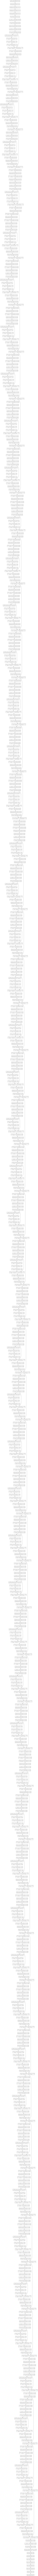

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(modeleffb7, show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = modeleffb7.fit(
    train_augmented,
    epochs=40,
    batch_size=1,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

In [ ]:
# Save the model
modeleffb7.save("Eff_b7modelv2.h5")

In [ ]:
# Load the model
from keras.models import load_model
loaded_model_effb7 = load_model("Eff_b7modelv2.h5")

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities for the test set
y_pred_prob = loaded_model_effb7.predict(test_augmented)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_augmented.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate the model on the test set
test_loss, test_acc = loaded_model_effb7.evaluate(test_augmented, verbose=1)
print("Test Accuracy:", test_acc)

report = classification_report(y_true, y_pred, output_dict=True)
print('Precision:', report['weighted avg']['precision'])
print('Recall:', report['weighted avg']['recall'])
print('F1 score:', report['weighted avg']['f1-score'])
print('Support:', report['weighted avg']['support'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='RdBu')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# ***Rescale***

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Rescaling
import tensorflow as tf

# Number of classes
classes = len(list(train_augmented.class_indices.keys()))

# Define the base model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a Rescaling layer before the base model
inputs = tf.keras.Input(shape=(256,256, 3))
x = Rescaling(1./255)(inputs)
x = base_model(x, training=True)

# Add the custom layers
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

# Add the final prediction layer
predictions = Dense(classes, activation='softmax')(x)

# Create the model
modeleffb7_rescale = Model(inputs=inputs, outputs=predictions)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
modeleffb7_rescale.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
modeleffb7_rescale.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

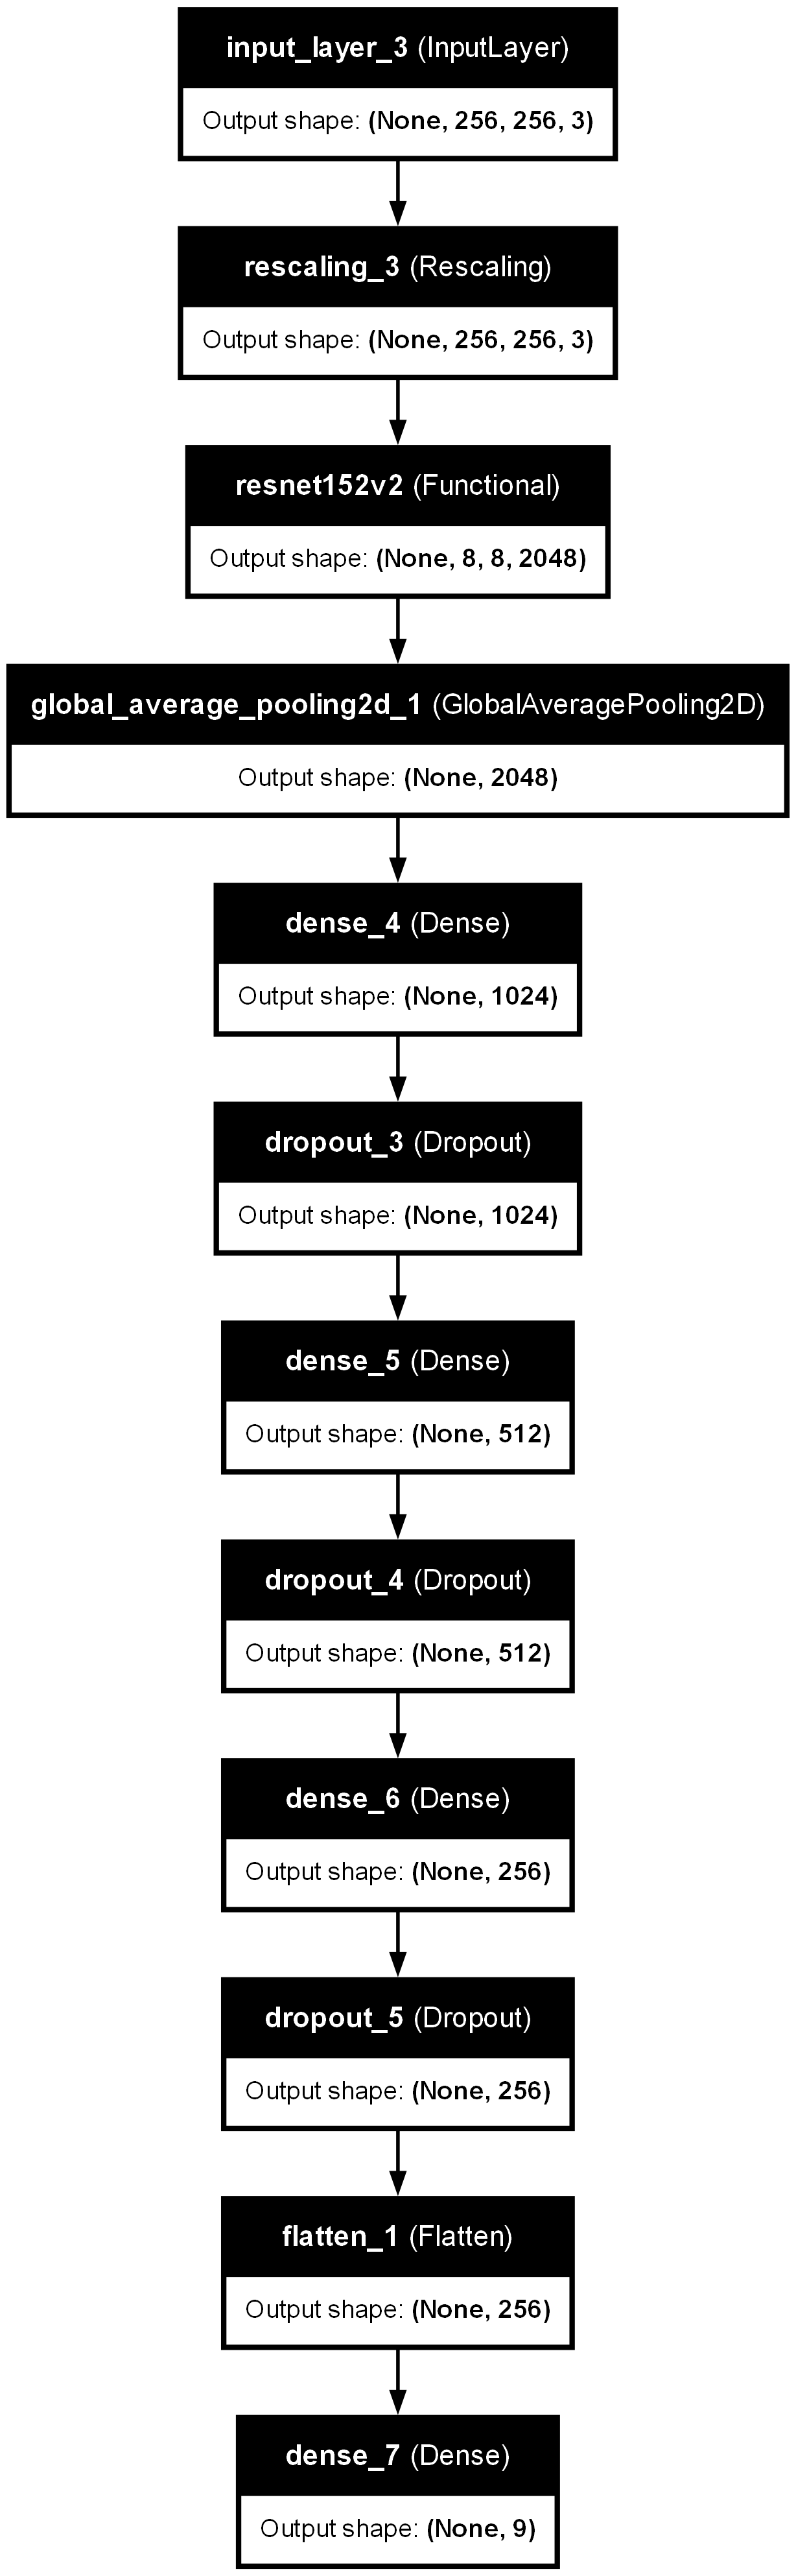

In [ ]:
 from tensorflow.keras.utils import plot_model
import pydot
plot_model(modeleffb7_rescale, to_file='modeleffb7.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = modeleffb7_rescale.fit(
    train_augmented,
    epochs= 50,
    batch_size=16,
    validation_data=valid_augmented,
    validation_steps=len(valid_augmented)
)

Epoch 1/50
495/495 [==============================] - 194s 359ms/step - loss: 1.4511 - accuracy: 0.4823 - val_loss: 0.7801 - val_accuracy: 0.7199
Epoch 2/50
495/495 [==============================] - 170s 343ms/step - loss: 0.9743 - accuracy: 0.6460 - val_loss: 0.5721 - val_accuracy: 0.7897
Epoch 3/50
495/495 [==============================] - 170s 342ms/step - loss: 0.8249 - accuracy: 0.7023 - val_loss: 0.4821 - val_accuracy: 0.8362
Epoch 4/50
495/495 [==============================] - 172s 348ms/step - loss: 0.7281 - accuracy: 0.7348 - val_loss: 0.4328 - val_accuracy: 0.8473
Epoch 5/50
495/495 [==============================] - 169s 341ms/step - loss: 0.6644 - accuracy: 0.7579 - val_loss: 0.3850 - val_accuracy: 0.8584
Epoch 6/50
495/495 [==============================] - 170s 343ms/step - loss: 0.6117 - accuracy: 0.7757 - val_loss: 0.3677 - val_accuracy: 0.8595
Epoch 7/50
495/495 [==============================] - 169s 341ms/step - loss: 0.5492 - accuracy: 0.7958 - val_loss: 0.3461 -

In [ ]:
# Save the model
modeleffb7_rescale.save("res_model_recsale.h5")

In [ ]:
import tensorflow as tf

# Load the saved model
modeleffb7 = tf.keras.models.load_model('Eff_b7model_recsale.h5')  # Load the model from the file

converter = tf.lite.TFLiteConverter.from_keras_model(modeleffb7)  # Pass the model object
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("try1.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\zubeen\AppData\Local\Temp\tmpu4qp4u_s\assets


INFO:tensorflow:Assets written to: C:\Users\zubeen\AppData\Local\Temp\tmpu4qp4u_s\assets


70755376